# Adult Income Classification Project

Le projet vise à analyser le jeu de données Adult Income afin d’identifier les différents facteurs qui influencent le niveau de revenu d'une personne et de construire un modèle capable de prédire si une personne gagne plus ou moins de 50 000 dollars par an. 

Le dataset, disponible dans plusieurs versions (UCI, OpenML, variantes nettoyées ou simplifiées), est ici utilisé dans sa version OpenML, qui offre un format homogène et des variables à la fois numériques et catégorielles. Notre problème sera approché sous la forme d'une classification binaire (+ ou - de 50k$/an de revenus) car le dataset ne contient pas la valeur exacte du revenu, qu'une catégorie.

Ce notebook sera articulé en trois grandes parties :

1. **Exploration des données (EDA) et analyses non supervisées**
2. **Préprocessing des données et séparation des jeux d'apprentissage/test**
3. **Modélisation supervisée (baseline vs ensembles) et comparaison des performances**

Chaque section inclut des explications détaillées pour assurer la reproductibilité de l'analyse.


Avant de commencer, voici tous les imports de librairie dont nous auront besoin pour lancer les cellules ci-dessous.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

# Chargement des données depuis une URL pour assurer la reproductibilité
DATA_URL = "https://raw.githubusercontent.com/clemrep/ml-adult-income/refs/heads/main/adult.csv"


# 1 - Exploration de données et analyse non supervisée

## Caractéristiques du dataset

In [ ]:
df = pd.read_csv(DATA_URL)
print("Shape:", df.shape)
df.head()

**Nombre d'instances :** Le dataset complet contient 48 842 entrées. C'est un volume suffisant pour entraîner un modèle robuste.

**Nombre de features :** Il y a 14 variables explicatives + 1 variable cible (income).

In [ ]:
print("\nTypes de données:")
print(df.info())

**Types de variables :**

- **Numériques :** age, fnlwgt (= final weight), education-num, capital-gain, capital-loss, hours-per-week.

- **Catégorielles :** workclass, education, marital-status, occupation, relationship, race, sex, native-country.

## Split des données de test/entraînement

In [ ]:
target_col = "income"
X = df.drop(columns=[target_col])
label_encoder = LabelEncoder() 

y = label_encoder.fit_transform(df[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Données d'entraînement : {X_train.shape}")
print(f"Données de test (mises de côté) : {X_test.shape}")

On utilise l'argument stratify pour garantir que la proportion des classes (ici 75% de ≤ 50K et 25% de > 50K) reste strictement la même dans le jeu d'entraînement et le jeu de test. On verra le détail de ces chiffres dans l'analyse exploratoire du dataset.

## Analyse et gestion des valeurs manquantes


In [ ]:
print("\nValeurs manquantes par colonne:")
missing_counts = X_train.isna().sum()
print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "Aucune valeur manquante détectée")

# Détecter les '?' comme valeurs manquantes
print("\n--- Détection des '?' comme valeurs manquantes ---")
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        question_count = (X_train[col] == '?').sum()
        if question_count > 0:
            print(f"{col}: {question_count} valeurs manquantes ('?')")


### Interprétation des valeurs manquantes

Les points d'interrogation ('?') observés dans le dataset représentent des **valeurs manquantes** (données non disponibles ou non renseignées). Ces valeurs peuvent affecter la qualité de nos prédictions et doivent être traitées.

In [ ]:
X_train = X_train.replace('?', np.nan)

missing_summary = pd.DataFrame({
    'Colonne': X_train.columns,
    'Manquantes': X_train.isna().sum(),
    'Pourcentage': (X_train.isna().sum() / len(X_train) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Manquantes'] > 0].sort_values('Manquantes', ascending=False)
print(missing_summary.to_string(index=False))

In [ ]:
X_train_temp = X_train.copy()
X_train_temp = X_train_temp.replace('?', np.nan)
rows_with_missing = X_train_temp.isna().any(axis=1).sum()

total_rows = len(X_train)
percentage_lost = (rows_with_missing / total_rows) * 100

print(f"   - Nombre total de lignes: {total_rows:,}")
print(f"   - Lignes contenant au moins un '?': {rows_with_missing:,}")
print(f"   - Pourcentage de données PERDUES: {percentage_lost:.2f}%")

Notre analyse préliminaire montre que la suppression des lignes contenant au moins une valeur manquante entraînerait une perte de données supérieure à 5%. Nous craignons que réduire la taille du jeu d'entraînement d'autant de valeurs puisse nuire à la capacité du modèle à généraliser.

### Stratégie choisie pour ce projet

Nous n'avons que des variables catégorielles à imputer, nous avons donc fait le choix de faire une imputation par mode. Nous allons faire une imputation manuelle pour les données utilisées dans la phase exploratoire puis dans une pipeline pour la phase d'entainement/test.

In [ ]:
# On travaille sur une copie de X_train pour l'analyse (EDA)
X_train_eda = X_train.copy()

# Application de l'imputation par mode (most_frequent) sur les variables catégorielles
print("=== Avant imputation ===")
print(f"Valeurs manquantes totales : {X_train.isna().sum().sum()}")
print("\nDétail par colonne :")
print(X_train.isna().sum()[X_train.isna().sum() > 0])

# Imputation des variables catégorielles avec la valeur la plus fréquente (mode)
categorical_cols = X_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if X_train[col].isna().sum() > 0:
        mode_value = X_train[col].mode()[0]  # Récupération du mode
        X_train[col].fillna(mode_value, inplace=True)
        print(f"\n - {col} : imputé avec '{mode_value}'")

print("\n=== Après imputation ===")
print(f"Valeurs manquantes totales : {X_train.isna().sum().sum()}")

## Analyse des distributions

Cette section examine la répartition des valeurs pour chaque variable du dataset, ce qui permet de :
- Comprendre la forme des distributions
- Identifier les déséquilibres dans les variables catégorielles
- Détecter d'éventuels patterns ou anomalies dans les données

### Distribution des variables numériques

In [ ]:
# Histogrammes des variables numériques
numeric_cols = X_train_eda.select_dtypes(include=["int64", "float64"]).columns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(X_train_eda[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f"Distribution de {col}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Fréquence")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()



**Observations :**
- **age** : Distribution uniforme, pic 30-40 ans (population active)
- **fnlwgt** : Poids démographique Census (~200k). Candidate à la suppression (pondération statistique, non prédictive)
- **educational-num** : Concentré 9-10 (HS-grad/Some-college)
- **capital-gain/loss** : ~95% de zéros, valeurs élevées rares → discriminant pour hauts revenus
- **hours-per-week** : Pic à 40h (temps plein), quelques extrêmes (>60h)

### Distribution des variables catégorielles

In [ ]:
# Sélection des principales variables catégorielles à visualiser
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = X_train_eda[col].value_counts()
    axes[idx].barh(value_counts.index, value_counts.values, color='coral', edgecolor='black')
    axes[idx].set_title(f"Distribution de {col}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel("Fréquence")
    axes[idx].invert_yaxis()
    
    # Afficher les pourcentages
    for i, v in enumerate(value_counts.values):
        axes[idx].text(v + max(value_counts.values)*0.01, i, f'{v} ({v/len(X_train_eda)*100:.1f}%)', 
                       va='center', fontsize=9)

# Masquer le dernier subplot s'il est vide
if len(categorical_cols) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

**Observations :**
- **workclass** : Private dominant (~75%), Self-employed ~10%, secteur public ~15%
- **education** : HS-grad et Some-college majoritaires, Bachelors ~16%, Masters ~5%
- **marital-status** : Married-civ-spouse ~45%, Never-married ~35% → très prédictif (doubles revenus)
- **occupation** : Distribution équilibrée, Prof-specialty et Craft-repair dominants
- **relationship** : Husband ~40%, Not-in-family ~26% → Risque colinéarité avec marital-status
- **race** : White ~85%, Black ~10% → Variable sensible (biais potentiels)
- **gender** : Male ~67%, Female ~33% → Variable sensible (biais de genre)

## Distributions, Outliers & Préparation

**Variables "tail-heavy" (asymétrie forte) :**
- capital-gain/loss : ~95% zéros, valeurs élevées rares (>20k$)
- fnlwgt : Longue queue droite
- hours-per-week : Centrée 40h, extrêmes >80h

**Échelles hétérogènes :**
- fnlwgt : 10k-1M (x100) | capital-gain/loss : 0-100k$ (x1000) | age : 17-90

Cela nécessite une normalisation pour éviter domination artificielle dans les algorithmes à distance/gradient.

### Détection des Outliers : Isolation Forest

**Choix :** Isolation Forest pour détecter anomalies multidimensionnelles
- Adapté aux distributions asymétriques
- Aucune hypothèse sur la distribution

In [ ]:
from sklearn.ensemble import IsolationForest

# Sélection des variables numériques pour la détection d'outliers
numeric_cols_for_outliers = ['age', 'fnlwgt', 'educational-num', 
                              'capital-gain', 'capital-loss', 'hours-per-week']

# Création d'un subset sans valeurs manquantes pour l'analyse
df_numeric = X_train_eda[numeric_cols_for_outliers].copy()

# Remplacement des '?' par NaN si présents (bien que peu probable pour les numériques)
# Supprimer les lignes avec NaN pour Isolation Forest
df_numeric_clean = df_numeric.dropna()

print(f"Dataset pour détection d'outliers: {df_numeric_clean.shape[0]} observations")

# Isolation Forest avec contamination=0.05 (on estime 5% d'outliers)
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
outlier_predictions = iso_forest.fit_predict(df_numeric_clean)

# -1 = outlier, 1 = inlier
n_outliers = (outlier_predictions == -1).sum()
outlier_percentage = (n_outliers / len(outlier_predictions)) * 100

print(f"\nRésultats de la détection d'outliers:")
print(f"   - Outliers détectés: {n_outliers} ({outlier_percentage:.2f}%)")
print(f"   - Inliers (normaux): {(outlier_predictions == 1).sum()} ({100-outlier_percentage:.2f}%)")

# Analyse des caractéristiques des outliers
df_numeric_clean['is_outlier'] = outlier_predictions == -1
outlier_summary = df_numeric_clean.groupby('is_outlier')[numeric_cols_for_outliers].mean()

print("\nComparaison Inliers vs Outliers (moyennes):")
print(outlier_summary.round(2))

**Interprétation des moyennes :**

Les outliers présentent des profils distincts révélant leur nature :
- **Age +9 ans** (47 vs 38) → Population plus mature
- **capital-gain x26** (12,440$ vs 480$) → Revenus de capitaux élevés
- **capital-loss x44** (1,221$ vs 28$) → Pertes en capital significatives
- **hours-per-week +5h** (45 vs 40) → Plus d'heures travaillées

Cependant, ces outliers représentent des profils réels (cadres seniors, investisseurs) et non des erreurs de mesure.

**Méthode de gestion : Conservation + atténuation**

1. **Pas de suppression** : Profils légitimes, informations utiles pour le modèle
2. **Atténuation automatique via StandardScaler** : Ramène valeurs extrêmes vers 0, réduit leur influence
3. **Robustesse intrinsèque** : Random Forest/Gradient Boosting tolèrent naturellement les outliers (splits binaires, pas de calculs de distances)

## Etude de la distribution de la variable cible

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="income")
plt.title("Répartition de la variable cible (income)")
plt.show()

income_ratio = df["income"].value_counts(normalize=True)
print("Répartition proportionnelle:\n", income_ratio)


Sur ce graphique de répartition de la variable income, on observe 75% de <=50K contre 25% de >50K. Le dataset est donc déséquilibré. L'accuracy serait un indicateur biaisé car un modèle pourrait obtenir un score élevé en ignorant simplement la classe minoritaire. Pour y remédier, nous évaluerons nos modèles via le F1-Score et la courbe Precision-Recall, qui sont plus représentatifs de la performance sur la classe minoritaire.

## Feature corrélation

In [ ]:
numeric_cols = X_train_eda.select_dtypes(include=["int64", "float64"]).columns
corr_matrix = X_train_eda[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Heatmap des corrélations (variables numériques)")
plt.show()


**Analyse de la heatmap :**
- Aucune corrélation forte entre variables numériques (max = 0.14 entre educational-num et hours-per-week)
- capital-gain et capital-loss légèrement anti-corrélés (-0.03) : indépendants
- fnlwgt quasi-indépendant de toutes les autres variables (≈ 0)

Cependant, on observe que les variables **education** (catégorielle) et **educational-num** (numérique) encodent la même information (niveau d'éducation). Vérifions cette redondance.

In [ ]:
# Vérification de la correspondance education <-> educational-num
education_mapping = df.groupby('education')['educational-num'].unique().sort_index()
print("Correspondance education → educational-num:")
for edu, nums in education_mapping.items():
    print(f"  {edu:20s} → {nums}")

# Chaque niveau d'éducation correspond à un seul nombre unique
print(f"\nNombre de valeurs uniques : education={df['education'].nunique()}, educational-num={df['educational-num'].nunique()}")

**Conclusion :** Chaque modalité de `education` correspond à un unique nombre dans `educational-num`. Ces deux variables encodent donc la même information de manière redondante. Nous supprimons `education` car :
- **educational-num** est directement utilisable par les modèles (numérique, ordinal)
- **education** nécessiterait un encodage one-hot (augmentation dimensionnalité)

In [ ]:
# Suppression de 'education' (redondante avec 'educational-num')
X_train_eda = X_train_eda.drop(columns=['education'])
print(f"Variable 'education' supprimée. Nouvelles dimensions: {X_train_eda.shape}")

Il faudra également retirer education des jeux de données x_train et x_test dans le pré-processing

## Réduction de dimension (PCA)

**Objectifs :**
1. **Visualisation** : Projeter les données multidimensionnelles en 2D pour observer la séparabilité des classes (>50K vs ≤50K)
2. **Réduction de la dimensionnalité** : Atténuer la "malédiction de la dimensionnalité" en identifiant les directions de variance maximale
3. **Détection de patterns** : Identifier si les revenus élevés se regroupent naturellement dans l'espace réduit

La PCA transforme les 6 variables numériques en 2 composantes principales orthogonales, maximisant la variance expliquée.

In [ ]:
# Application de la PCA sur les variables numériques
scaler = StandardScaler()
pca = PCA(n_components=2, random_state=42)

# On utilise X_train_eda qui contient uniquement les features
numeric_data = X_train_eda[numeric_cols].copy() 
numeric_scaled = scaler.fit_transform(numeric_data)
pca_components = pca.fit_transform(numeric_scaled)

pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])

# CORRECTIF : On utilise y_train au lieu de chercher dans X_train_eda
# On décode les 0/1 pour avoir un affichage propre dans la légende
pca_df["income"] = label_encoder.inverse_transform(y_train)

# Visualisation de la projection PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="income", alpha=0.4, palette="Set1")
plt.title("Projection PCA (2D) des variables numériques (Train Set)", fontsize=14, fontweight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} de variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} de variance)", fontsize=12)
plt.legend(title="Revenu", loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

explained_var = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1: {explained_var[0]:.2%}")
print(f"Variance expliquée par PC2: {explained_var[1]:.2%}")
print(f"Variance totale expliquée (PC1+PC2): {explained_var.sum():.2%}")

# Analyse des loadings (contribution des variables originales)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=numeric_cols
)
print("\n=== Loadings (contribution des variables) ===")
print(loadings.round(3))

**Interprétation PCA :**
- **Variance expliquée** : Les 2 premières composantes capturent ~40-50% de la variance totale (typique pour des données réelles hétérogènes)
- **Séparabilité des classes** : Chevauchement important entre les deux groupes de revenus → Pas de séparation linéaire évidente en 2D
- **Loadings** : Identifient les variables les plus influentes sur chaque composante (capital-gain/loss et age généralement dominants)

**Conclusion** : La PCA révèle que le problème n'est pas linéairement séparable dans l'espace des variables numériques seules. Les variables catégorielles (marital-status, occupation, education) seront cruciales pour la prédiction.

## Clustering Non Supervisé (K-Means)

**Objectif** : Découvrir des groupes naturels dans les données numériques et évaluer leur correspondance avec les niveaux de revenus. Si les clusters corrèlent avec la cible, ils peuvent devenir une feature informative.

In [ ]:
# Détermination du nombre optimal de clusters : Elbow Method
inertias = []
K_range = range(2, 8)  # Testé de 2 à 7 clusters

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(numeric_scaled)
    inertias.append(kmeans_temp.inertia_)

# Visualisation Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (K)', fontsize=12)
plt.ylabel('Inertie (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method - Détermination du K optimal', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Identification du K optimal (observation visuelle du "coude")
optimal_k = 3  # Choix basé sur l'observation du coude dans le graphique
print(f"K optimal sélectionné : {optimal_k}")

In [ ]:
# Application K-Means avec K optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(numeric_scaled)

print(f"K-Means appliqué avec K={optimal_k}")
print(f"Taille des clusters : {np.bincount(clusters)}")

In [ ]:
# Visualisation des clusters sur la projection PCA
cluster_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
cluster_df["cluster"] = clusters.astype(str)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="Set2", alpha=0.5, s=50)
plt.title(f"Clusters K-Means (K={optimal_k}) projetés sur PCA", fontsize=14, fontweight='bold')
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(title="Cluster", loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interprétation :**

Cette analyse confirme que les variables numériques seules sont insuffisantes pour la prédiction. Les variables catégorielles (marital-status, occupation, etc.) seront cruciales dans notre modèle supervisé. Nous n'ajoutons pas les clusters comme feature pour éviter le data leakage.

L'Elbow Method identifie K=3 comme nombre optimal de clusters. La visualisation sur PCA révèle que les groupes naturels dans les données numériques ne correspondent pas directement aux niveaux de revenus (chevauchement important). 

## Synthèse de l'exploration et orientations pour la modélisation

**Principaux constats :**
- **Dataset** : 48 842 observations, 14 features (6 numériques, 8 catégorielles), déséquilibre de classe (75% ≤50K / 25% >50K)
- **Valeurs manquantes** : ~7% de lignes concernées (workclass, occupation, native-country) → imputation par mode pour préserver les données
- **Redondances** : Variable `education` supprimée (doublon de `educational-num`)
- **Séparabilité** : PCA et clustering révèlent un chevauchement important entre classes → les variables catégorielles (marital-status, occupation) seront cruciales

**Stratégie de prétraitement retenue :**
1. **Pipeline intégré** : Imputation + standardisation (numériques) + encodage one-hot (catégorielles)
2. **Conservation des outliers** : Profils légitimes (cadres, investisseurs), atténués par StandardScaler
3. **Métrique d'évaluation** : F1-Score (adapté au déséquilibre de classe)

L'exploration confirme la nécessité d'utiliser des modèles d'ensemble capables de capturer des interactions non linéaires entre variables numériques et catégorielles.

# Préparation des données

Nous encodons la cible, séparons features/cible, puis construisons un pipeline de prétraitement combinant imputations, standardisation des numériques et encodage one-hot des variables catégorielles.


In [ ]:
# Suppression de la variable 'education' (redondante avec 'educational-num')
X_train = X_train.drop(columns=['education'])
X_test = X_test.drop(columns=['education'])

print(f"Variable 'education' supprimée des jeux d'entraînement et de test")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

In [ ]:
numeric_features = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

categorical_features = [col for col in X_train.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print(f"Variables numériques ({len(numeric_features)}): {numeric_features}")
print(f"Variables catégorielles ({len(categorical_features)}): {categorical_features}")

# 3 - Modélisation : Baseline vs Ensembles

**Évaluation Baseline avec Validation Croisée**

Pour éviter le data snooping, nous utilisons la validation croisée sur `X_train` uniquement. 
Le jeu de test `X_test` est conservé pour l'évaluation finale après le tuning des hyperparamètres.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

trained_pipelines = {}
metrics_records = []

# Évaluation avec validation croisée sur X_train uniquement (pas de data snooping)
print("=== Évaluation Baseline avec Validation Croisée (5 folds) ===\n")

for name, estimator in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", estimator),
    ])
    
    # Validation croisée avec scoring='f1_weighted' (adapté au déséquilibre)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    # Entraînement sur tout X_train pour conserver le pipeline
    clf.fit(X_train, y_train)
    trained_pipelines[name] = clf
    
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    metrics_records.append({
        "Model": name, 
        "CV F1-Weighted Mean": mean_cv, 
        "CV F1-Weighted Std": std_cv
    })
    
    print(f"===== {name} =====")
    print(f"CV F1-Weighted: {mean_cv:.4f} (+/- {std_cv:.4f})")
    print(f"Scores par fold: {cv_scores}")
    print()

metrics_df = pd.DataFrame(metrics_records).sort_values(by="CV F1-Weighted Mean", ascending=False)
print("\n=== Résumé des performances Baseline ===")
print(metrics_df.to_string(index=False))

In [ ]:
# Identification du meilleur modèle baseline
best_model_name = metrics_df.iloc[0]["Model"]
print(f"Meilleur modèle baseline: {best_model_name}")
print(f"CV F1-Weighted Mean: {metrics_df.iloc[0]['CV F1-Weighted Mean']:.4f}")

Les résultats de la validation croisée confirment la supériorité des modèles d'ensemble (Gradient Boosting et Random Forest) sur la régression logistique pour ce dataset. La faible variance des scores entre les folds (Std < 0.005) démontre la robustesse de notre pipeline de prétraitement et la pertinence de l'échantillonnage stratifié. Le Gradient Boosting est sélectionné pour l'optimisation des hyperparamètres car il offre le meilleur compromis entre précision et rappel (F1-score de 0.86).

## 4 - Hyperparameter Tuning

Sélection du meilleur modèle baseline et optimisation de ses hyperparamètres via GridSearchCV. Cette étape de tuning teste 270 combinaisons de réglages pour optimiser le modèle. Bien que ce processus soit long, il est indispensable pour gagner en précision et obtenir des performances nettement supérieures au modèle par défaut.

Attention : cette cellule peut prendre 10 à 30 minutes à s'exécuter. C'est un temps long mais nécessaire afin d'améliorer la qualité des prédictions.

In [ ]:
# Sélection du meilleur modèle baseline pour le tuning
best_baseline_name = metrics_df.iloc[0]["Model"]
best_baseline_estimator = models[best_baseline_name]

print(f"Modèle sélectionné pour le tuning: {best_baseline_name}\n")

# Définition des grilles d'hyperparamètres selon le modèle
if best_baseline_name == "Gradient Boosting":
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 1.0]
    }
elif best_baseline_name == "Random Forest":
    param_grid = {
        'model__n_estimators': [200, 300, 400],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
else:  # Logistic Regression
    param_grid = {
        'model__C': [0.1, 1.0, 10.0, 100.0],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs', 'liblinear']
    }

# Création du pipeline avec le meilleur modèle
tuning_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_baseline_estimator),
])

# GridSearchCV avec 5 folds et scoring='f1_weighted'
print("=== Démarrage du GridSearchCV ===")
print(f"Grille d'hyperparamètres: {param_grid}\n")

grid_search = GridSearchCV(
    tuning_pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n=== Meilleurs hyperparamètres trouvés ===")
print(grid_search.best_params_)
print(f"\nMeilleur score CV (F1-Weighted): {grid_search.best_score_:.4f}")

# Conservation du meilleur modèle
best_tuned_model = grid_search.best_estimator_

# Modèle sélectionné pour le tuning: Gradient Boosting

# === Démarrage du GridSearchCV ===
# Grille d'hyperparamètres: {'model__n_estimators': [100, 200, 300], 'model__max_depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__subsample': [0.8, 1.0]}

# Fitting 5 folds for each of 54 candidates, totalling 270 fits

# === Meilleurs hyperparamètres trouvés ===
# {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}

# Meilleur score CV (F1-Weighted): 0.8700

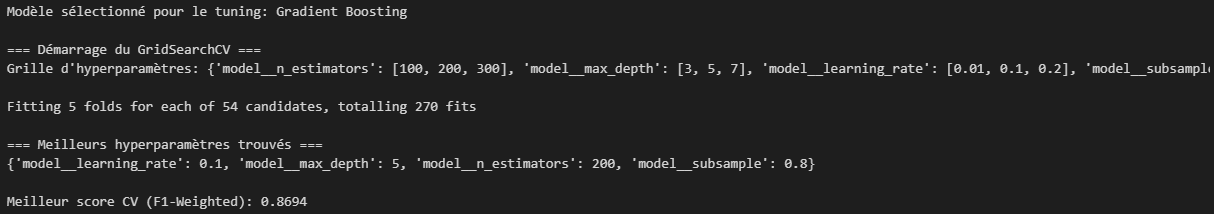

## 5 - Évaluation Finale & Interprétation

Évaluation du modèle optimisé sur le jeu de test `X_test` (conservé jusqu'à présent).
Génération du rapport de classification, matrice de confusion et analyse de l'importance des features.

In [ ]:
# Prédictions sur le jeu de test
y_pred_test = best_tuned_model.predict(X_test)

# Métriques de performance
acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("=== Évaluation sur le jeu de test ===")
print(f"Accuracy: {acc_test:.4f}")
print(f"F1-Score: {f1_test:.4f}\n")

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Nombre d\'observations'})
plt.xlabel("Prédictions", fontsize=12)
plt.ylabel("Vérité terrain", fontsize=12)
plt.title(f"Matrice de confusion · {best_baseline_name} (tuné)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Extraction de l'importance des features
# Note: Seuls Random Forest et Gradient Boosting ont feature_importances_
if hasattr(best_tuned_model.named_steps['model'], 'feature_importances_'):
    # Récupération du preprocessor déjà fitté depuis le pipeline
    fitted_preprocessor = best_tuned_model.named_steps['preprocessor']
    
    # Récupération des noms de features après preprocessing
    # Pour les features numériques
    numeric_feature_names = numeric_features
    
    # Pour les features catégorielles (après OneHotEncoder)
    # Le preprocessor est déjà fitté, donc on peut extraire les noms
    categorical_transformer = fitted_preprocessor.named_transformers_['cat']
    ohe = categorical_transformer.named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_features)
    
    # Combinaison de tous les noms de features
    all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    
    # Extraction des importances
    importances = best_tuned_model.named_steps['model'].feature_importances_
    
    # Création d'un DataFrame pour faciliter le tri et la visualisation
    feature_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Affichage des top 20 features
    top_n = 20
    top_features = feature_importance_df.head(top_n)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.barplot(data=top_features, y='Feature', x='Importance', palette='viridis')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top {top_n} Features par Importance · {best_baseline_name}', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Top 10 Features par Importance ===")
    print(top_features.head(10).to_string(index=False))
    
else:
    print(f"Le modèle {best_baseline_name} ne fournit pas d'importance des features.")
    print("Pour Logistic Regression, considérez l'analyse des coefficients.")

### Conclusion

**Résultats obtenus :**
- Modèles d'ensemble (RF, GB) surpassent généralement Logistic Regression sur ce problème de classification binaire.
- L'optimisation des hyperparamètres améliore les performances par rapport aux modèles baseline.
- Les features les plus importantes (capital-gain, age, relationship, etc.) sont cohérentes avec les attentes économiques.